In [ ]:
from epymorph.parameter_fitting.filters.particle_filter import ParticleFilter
from epymorph.parameter_fitting.likelihoods.poisson import PoissonLikelihood
from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation
from epymorph.parameter_fitting.utils.observations import Observations
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters

from epymorph.parameter_fitting.dynamics.dynamics import GeometricBrownianMotion
import scipy
from epymorph.adrio import acs5, csv


In [2]:
from epymorph.data_shape import Shapes
from epymorph.initializer import Initializer
from epymorph.simulation import AttributeDef

import numpy as np


class PFInitializer(Initializer):
    requirements = [AttributeDef("population", int, Shapes.N)]

    def __init__(self, index2=0, index3=0, index4=0) -> None:
        self.index2 = index2
        self.index3 = index3
        self.index4 = index4

    def evaluate(self):
        total_population = self.data("population")[0]  # 7_174_064
        # initial_particle cloud
        initializer = np.array(
            [
                [
                    total_population - self.index2 - self.index3 - self.index4,
                    self.index2,
                    self.index3,
                    self.index4,
                ]
            ],
            dtype=np.int64,
        )
        return initializer

In [3]:
# ruff: noqa: F405
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import Sirh
from epymorph.data.mm.no import No


rume = SingleStrataRume.build(
    # Load an IPM from the library
    ipm=Sirh(),
    # Load an MM from the library
    mm=No(),
    # Use our scope
    scope=StateScope.in_states(["AZ"], year=2015),
    # Create a SingleLocation initializer
    # Provide an initializer of your coice or create a custom initializer as
    # above and pass it
    init=PFInitializer(50, 1434813, 23),
    # Set the time-frame to simulate
    time_frame=TimeFrame.of("2022-10-01", 371),
    # Provide parameter values
    params={
        # "beta": To be estimated,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.03,
        "hospitalization_duration": 5.0,
        # Geographic data can be loaded using ADRIOs
        "population": acs5.Population(),
    },
)

In [4]:
[e.name.full for e in rume.ipm.events]

['S → I', 'I → H', 'I → R', 'H → R', 'R → S']

In [5]:
likelihood_fn = PoissonLikelihood()
filter_type = ParticleFilter(num_particles=250)

In [6]:
from pathlib import Path

csvadrio = csv.CSVTimeSeries(
    file_path=Path("./influenza.csv"),
    time_col=0,
    time_frame=TimeFrame.range("2022-10-01", "2023-09-30"),
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [7]:
# observations = Observations(
#     InfluenzaHospitalizationSumState(rume.time_frame),
#     model_link="I → H",
# )

observations = Observations(
    csvadrio,
    model_link="I → H",
)


In [8]:
params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=scipy.stats.uniform(loc=0.1, scale=0.7),
        dynamics=GeometricBrownianMotion(volatility=0.1),
    )
}

In [9]:
sim = FilterSimulation(
    rume=rume,
    observations=observations,
    likelihood_fn=likelihood_fn,
    filter_type=filter_type,
    params_space=params_space,
)

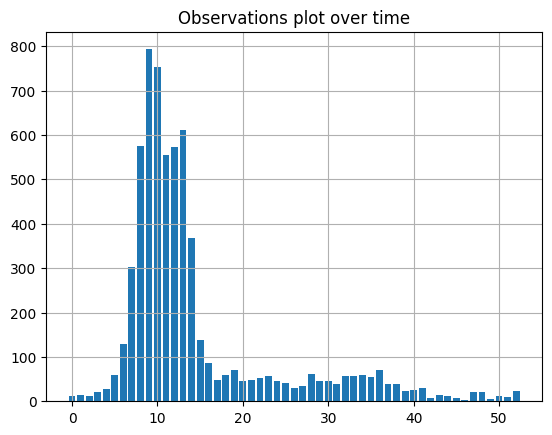

In [10]:
sim.plot_data()

In [11]:
output = sim.run()

Running Particle Filter simulation
• 2022-10-01 00:00:00 to 2023-09-30 00:00:00 (371 days)
• 250 particles

Simulation completed in 92.93s

Parameters estimated: ['beta']


In [12]:
output

ParticleFilterOutput(num_particles=250, parameters_estimated=['beta'], duration='371 days', param_quantiles={'beta': [array([[0.10757812],
       [0.12856418],
       [0.14858566],
       [0.17596709],
       [0.21815879],
       [0.24685673],
       [0.27200326],
       [0.32308857],
       [0.37318822],
       [0.41913389],
       [0.43547994],
       [0.49333772],
       [0.53660811],
       [0.57531021],
       [0.62201998],
       [0.64323352],
       [0.66610768],
       [0.69187206],
       [0.71782005],
       [0.76940082],
       [0.78551836],
       [0.79176938],
       [0.79442146]]), array([[0.39702202],
       [0.39702202],
       [0.39702202],
       [0.48391093],
       [0.52759176],
       [0.58705839],
       [0.5964137 ],
       [0.60600657],
       [0.60665669],
       [0.6514333 ],
       [0.6514333 ],
       [0.69769348],
       [0.71897469],
       [0.73653329],
       [0.7499192 ],
       [0.82555676],
       [0.86440737],
       [0.95146745],
       [1.05251778]

In [13]:
print(output)

Particle Filter Output
-----------------------

Number of Particles: 250

Duration: 371 days

Parameters estimated: ['beta']

Parameter Quantiles: represent the statistical range of parameter estimates at different percentiles (e.g., 5th, 50th, 95th percentiles).

Parameter Values: represent the values of model parametersestimated in the simulation.

True Data: represents the actual observed data used for comparison.
  Data length: 53 entries.

Model Estimated Data: represents the data generated by the model forcomparison against the true data.
  Data length: 53 entries.


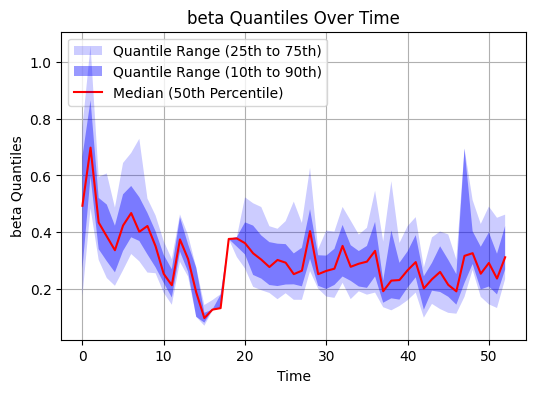

In [20]:
output.plot.params_plot(parameter="beta")

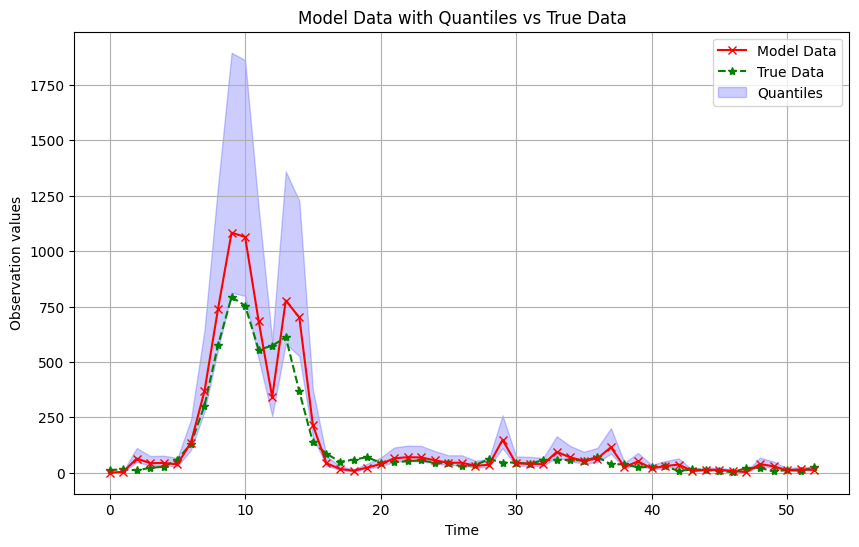

In [17]:
output.plot.model_fit()